In [2]:
import random
import numpy as np
import os
import torch as torch
import pickle

In [4]:
data_path = '../dataset'
market_name = 'NASDAQ'
relation_name = 'wikidata'
stock_num = 1026
lookback_length = 16
epochs = 100
valid_index = 756
test_index = 1008
fea_num = 5
market_num = 20
steps = 1
learning_rate = 0.001
alpha = 0.1
scale_factor = 3
activation = 'GELU'

In [13]:


dataset_path = 'dataset/' + market_name
if market_name == "SP500":
    data = np.load('dataset/SP500/SP500.npy')
    data = data[:, 915:, :]
    price_data = data[:, :, -1]
    mask_data = np.ones((data.shape[0], data.shape[1]))
    eod_data = data
    gt_data = np.zeros((data.shape[0], data.shape[1]))
    for ticket in range(0, data.shape[0]):
        for row in range(1, data.shape[1]):
            gt_data[ticket][row] = (data[ticket][row][-1] - data[ticket][row - steps][-1]) / \
                                   data[ticket][row - steps][-1]
else:
    with open(os.path.join(dataset_path, "eod_data.pkl"), "rb") as f:
        eod_data = pickle.load(f)
    with open(os.path.join(dataset_path, "mask_data.pkl"), "rb") as f:
        mask_data = pickle.load(f)
    with open(os.path.join(dataset_path, "gt_data.pkl"), "rb") as f:
        gt_data = pickle.load(f)
    with open(os.path.join(dataset_path, "price_data.pkl"), "rb") as f:
        price_data = pickle.load(f)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

acv = nn.GELU()

def get_loss(prediction, ground_truth, base_price, mask, batch_size, alpha):
    device = prediction.device
    all_one = torch.ones(batch_size, 1, dtype=torch.float32).to(device)
    return_ratio = torch.div(torch.sub(prediction, base_price), base_price)
    reg_loss = F.mse_loss(return_ratio * mask, ground_truth * mask)
    pre_pw_dif = torch.sub(
        return_ratio @ all_one.t(),
        all_one @ return_ratio.t()
    )
    gt_pw_dif = torch.sub(
        all_one @ ground_truth.t(),
        ground_truth @ all_one.t()
    )
    mask_pw = mask @ mask.t()
    rank_loss = torch.mean(
        F.relu(pre_pw_dif * gt_pw_dif * mask_pw)
    )
    loss = reg_loss + alpha * rank_loss
    return loss, reg_loss, rank_loss, return_ratio


class MixerBlock(nn.Module):
    def __init__(self, mlp_dim, hidden_dim, dropout=0.0):
        super(MixerBlock, self).__init__()
        self.mlp_dim = mlp_dim
        self.dropout = dropout

        self.dense_1 = nn.Linear(mlp_dim, hidden_dim)
        self.LN = acv
        self.dense_2 = nn.Linear(hidden_dim, mlp_dim)

    def forward(self, x):
        x = self.dense_1(x)
        x = self.LN(x)
        if self.dropout != 0.0:
            x = F.dropout(x, p=self.dropout)
        x = self.dense_2(x)
        if self.dropout != 0.0:
            x = F.dropout(x, p=self.dropout)
        return x


class Mixer2d(nn.Module):
    def __init__(self, time_steps, channels):
        super(Mixer2d, self).__init__()
        self.LN_1 = nn.LayerNorm([time_steps, channels])
        self.LN_2 = nn.LayerNorm([time_steps, channels])
        self.timeMixer = MixerBlock(time_steps, time_steps)
        self.channelMixer = MixerBlock(channels, channels)

    def forward(self, inputs):
        x = self.LN_1(inputs)
        x = x.permute(0, 2, 1)
        x = self.timeMixer(x)
        x = x.permute(0, 2, 1)

        x = self.LN_2(x + inputs)
        y = self.channelMixer(x)
        return x + y


class TriU(nn.Module):
    def __init__(self, time_step):
        super(TriU, self).__init__()

        self.time_step = time_step
        self.triU = nn.ParameterList(
            [
                nn.Linear(i + 1, 1)
                for i in range(time_step)
            ]
        )

    def forward(self, inputs):
        x = self.triU[0](inputs[:, :, 0].unsqueeze(-1))
        for i in range(1, self.time_step):
            x = torch.cat([x, self.triU[i](inputs[:, :, 0:i + 1])], dim=-1)
        return x


class TimeMixerBlock(nn.Module):
    def __init__(self, time_step):
        super(TimeMixerBlock, self).__init__()
        self.time_step = time_step
        self.dense_1 = TriU(time_step)
        self.LN = acv
        self.dense_2 = TriU(time_step)

    def forward(self, x):
        x = self.dense_1(x)
        x = self.LN(x)
        x = self.dense_2(x)
        return x


class MultiScaleTimeMixer(nn.Module):
    def __init__(self, time_step, channel, scale_count=1):
        super(MultiScaleTimeMixer, self).__init__()
        self.time_step = time_step
        self.scale_count = scale_count
        self.mix_layer = nn.ParameterList([nn.Sequential(
            nn.Conv1d(in_channels=channel, out_channels=channel, kernel_size=2 ** i, stride=2 ** i),
            TriU(int(time_step / 2 ** i)),
            nn.Hardswish(),
            TriU(int(time_step / 2 ** i))
        ) for i in range(scale_count)])
        self.mix_layer[0] = nn.Sequential(
            nn.LayerNorm([time_step, channel]),
            TriU(int(time_step)),
            nn.Hardswish(),
            TriU(int(time_step))
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        y = self.mix_layer[0](x)
        for i in range(1, self.scale_count):
            y = torch.cat((y, self.mix_layer[i](x)), dim=-1)
        return y


class Mixer2dTriU(nn.Module):
    def __init__(self, time_steps, channels):
        super(Mixer2dTriU, self).__init__()
        self.LN_1 = nn.LayerNorm([time_steps, channels])
        self.LN_2 = nn.LayerNorm([time_steps, channels])
        self.timeMixer = TriU(time_steps)
        self.channelMixer = MixerBlock(channels, channels)

    def forward(self, inputs):
        x = self.LN_1(inputs)
        x = x.permute(0, 2, 1)
        x = self.timeMixer(x)
        x = x.permute(0, 2, 1)

        x = self.LN_2(x + inputs)
        y = self.channelMixer(x)
        return x + y


class MultTime2dMixer(nn.Module):
    def __init__(self, time_step, channel, scale_dim=8):
        super(MultTime2dMixer, self).__init__()
        self.mix_layer = Mixer2dTriU(time_step, channel)
        self.scale_mix_layer = Mixer2dTriU(scale_dim, channel)

    def forward(self, inputs, y):
        y = self.scale_mix_layer(y)
        x = self.mix_layer(inputs)
        return torch.cat([inputs, x, y], dim=1)


class NoGraphMixer(nn.Module):
    def __init__(self, stocks, hidden_dim=20):
        super(NoGraphMixer, self).__init__()
        self.dense1 = nn.Linear(stocks, hidden_dim)
        self.activation = nn.Hardswish()
        self.dense2 = nn.Linear(hidden_dim, stocks)
        self.layer_norm_stock = nn.LayerNorm(stocks)

    def forward(self, inputs):
        x = inputs
        x = x.permute(1, 0)
        x = self.layer_norm_stock(x)
        x = self.dense1(x)
        x = self.activation(x)
        x = self.dense2(x)
        x = x.permute(1, 0)
        return x






In [15]:
np.random.seed(123456789)
torch.random.manual_seed(12345678)
device = torch.device("cuda") if torch.cuda.is_available() else 'cpu'

In [16]:
class StockMixer(nn.Module):
    def __init__(self, stocks, time_steps, channels, market, scale):
        super(StockMixer, self).__init__()
        scale_dim = 8
        self.mixer = MultTime2dMixer(time_steps, channels, scale_dim=scale_dim)
        self.channel_fc = nn.Linear(channels, 1)
        self.time_fc = nn.Linear(time_steps * 2 + scale_dim, 1)

        # ///todo what is this line doing?
        self.conv = nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=2, stride=2)
        self.stock_mixer = NoGraphMixer(stocks, market)
        self.time_fc_ = nn.Linear(time_steps * 2 + scale_dim, 1)

    def forward(self, inputs):
        #input--- > torch.Size([474, 16, 5])


        # x =====> torch.Size([474, 5, 16])
        x = inputs.permute(0, 2, 1)

        # x after conv torch.Size([474, 5, 8])

        x = self.conv(x)

        # x after permute torch.Size([474, 8 , 5])
        x = x.permute(0, 2, 1)

        y = self.mixer(inputs, x)
        y = self.channel_fc(y).squeeze(-1)

        z = self.stock_mixer(y)
        y = self.time_fc(y)
        z = self.time_fc_(z)
        return y + z

In [26]:
trade_dates = mask_data.shape[1]
model = StockMixer(
    stocks=stock_num,
    time_steps=lookback_length,
    channels=fea_num,
    market=market_num,
    scale=scale_factor
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_valid_loss = np.inf
best_valid_perf = None
best_test_perf = None
batch_offsets = np.arange(start=0, stop=valid_index, dtype=int)

In [27]:
def get_batch(offset=None):
    if offset is None:
        offset = random.randrange(0, valid_index)
    seq_len = lookback_length
    mask_batch = mask_data[:, offset: offset + seq_len + steps]
    mask_batch = np.min(mask_batch, axis=1)
    return (
        eod_data[:, offset:offset + seq_len, :],
        np.expand_dims(mask_batch, axis=1),
        np.expand_dims(price_data[:, offset + seq_len - 1], axis=1),
        np.expand_dims(gt_data[:, offset + seq_len + steps - 1], axis=1))



In [21]:
pip install git+https://github.com/mert-kurttutan/torchview.git

  Cloning https://github.com/mert-kurttutan/torchview.git to /tmp/pip-req-build-t5et6xjh
  Running command git clone --filter=blob:none --quiet https://github.com/mert-kurttutan/torchview.git /tmp/pip-req-build-t5et6xjh
  Resolved https://github.com/mert-kurttutan/torchview.git to commit c640a4a55e49183fe05a8673f0a6d43943fbe84b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torchview: filename=torchview-0.2.6-py3-none-any.whl size=25416 sha256=89df6cab3f85517bd2d8584d5cdf7e28388cfb00bb3d1956f5bafb6379416a0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-0jp2pir6/wheels/da/1e/01/dc3f612d3119cde4bff91b0aa192bdf07d67e6a7a981baa686
Successfully built torchview


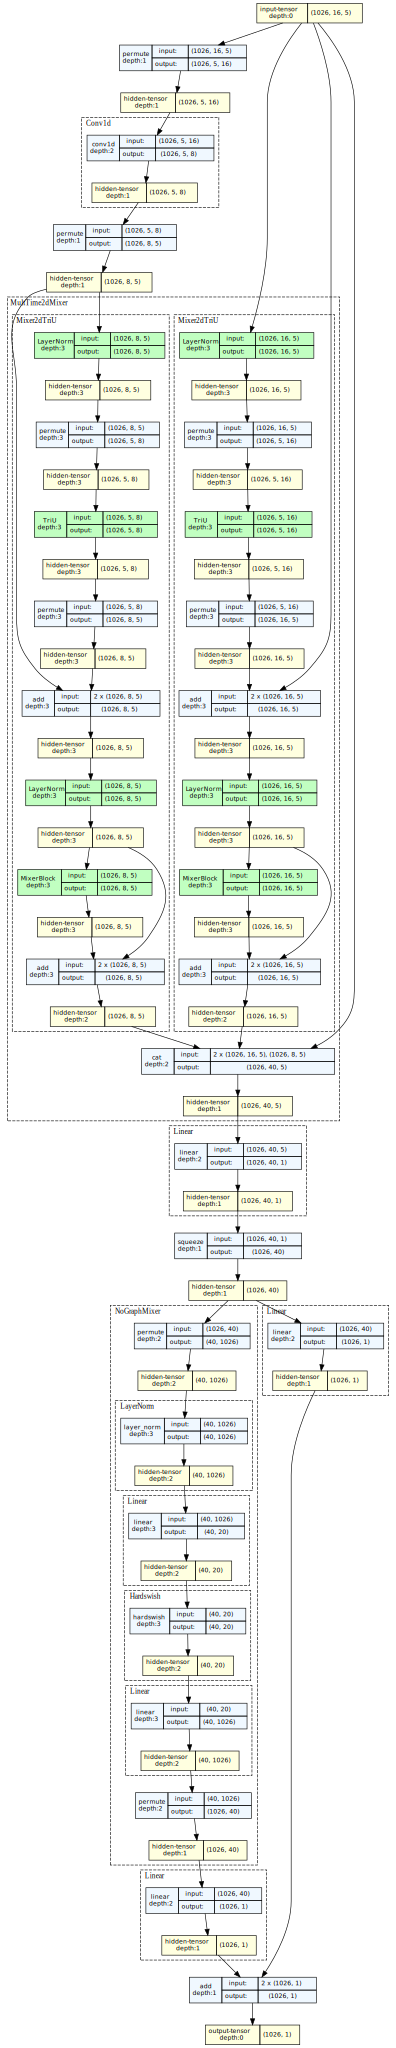

In [33]:
from torchview import draw_graph


batch_size = 2
# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(1026, 16, 5 ), device=device,expand_nested=True,hide_inner_tensors=False,hide_module_functions=False,save_graph=True,)
model_graph.visual_graph

In [34]:
pip install torchviz

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5

In [35]:
from torchviz import make_dot


In [28]:
def validate(start_index, end_index):
    with torch.no_grad():
        cur_valid_pred = np.zeros([stock_num, end_index - start_index], dtype=float)
        cur_valid_gt = np.zeros([stock_num, end_index - start_index], dtype=float)
        cur_valid_mask = np.zeros([stock_num, end_index - start_index], dtype=float)
        loss = 0.
        reg_loss = 0.
        rank_loss = 0.
        for cur_offset in range(start_index - lookback_length - steps + 1, end_index - lookback_length - steps + 1):
            data_batch, mask_batch, price_batch, gt_batch = map(

                lambda x: torch.Tensor(x).to(device),
                get_batch(cur_offset)
            )
            prediction = model(data_batch)
            cur_loss, cur_reg_loss, cur_rank_loss, cur_rr = get_loss(prediction, gt_batch, price_batch, mask_batch,
                                                                     stock_num, alpha)
            loss += cur_loss.item()
            reg_loss += cur_reg_loss.item()
            rank_loss += cur_rank_loss.item()
            cur_valid_pred[:, cur_offset - (start_index - lookback_length - steps + 1)] = cur_rr[:, 0].cpu()
            cur_valid_gt[:, cur_offset - (start_index - lookback_length - steps + 1)] = gt_batch[:, 0].cpu()
            cur_valid_mask[:, cur_offset - (start_index - lookback_length - steps + 1)] = mask_batch[:, 0].cpu()
        loss = loss / (end_index - start_index)
        reg_loss = reg_loss / (end_index - start_index)
        rank_loss = rank_loss / (end_index - start_index)
        cur_valid_perf = evaluate(cur_valid_pred, cur_valid_gt, cur_valid_mask)
    return loss, reg_loss, rank_loss, cur_valid_perf



In [38]:
def evaluate(prediction, ground_truth, mask, report=False):
    assert ground_truth.shape == prediction.shape, 'shape mis-match'
    performance = {}
    # mse
    performance['mse'] = np.linalg.norm((prediction - ground_truth) * mask) ** 2 / np.sum(mask)
    # IC
    df_pred = pd.DataFrame(prediction * mask)
    df_gt = pd.DataFrame(ground_truth * mask)

    ic = []
    mrr_top = 0.0
    all_miss_days_top = 0
    bt_long = 1.0
    bt_long5 = 1.0
    bt_long10 = 1.0
    irr = 0.0
    sharpe_li5 = []
    prec_10 = []

    for i in range(prediction.shape[1]):
        # IC
        ic.append(df_pred[i].corr(df_gt[i]))

        rank_gt = np.argsort(ground_truth[:, i])
        gt_top1 = set()
        gt_top5 = set()
        gt_top10 = set()

        for j in range(1, prediction.shape[0] + 1):
            cur_rank = rank_gt[-1 * j]
            if mask[cur_rank][i] < 0.5:
                continue
            if len(gt_top1) < 1:
                gt_top1.add(cur_rank)
            if len(gt_top5) < 5:
                gt_top5.add(cur_rank)
            if len(gt_top10) < 10:
                gt_top10.add(cur_rank)

        rank_pre = np.argsort(prediction[:, i])
        pre_top1 = set()
        pre_top5 = set()
        pre_top10 = set()
        for j in range(1, prediction.shape[0] + 1):
            cur_rank = rank_pre[-1 * j]
            if mask[cur_rank][i] < 0.5:
                continue
            if len(pre_top1) < 1:
                pre_top1.add(cur_rank)
            if len(pre_top5) < 5:
                pre_top5.add(cur_rank)
            if len(pre_top10) < 10:
                pre_top10.add(cur_rank)

        top1_pos_in_gt = 0
        for j in range(1, prediction.shape[0] + 1):
            cur_rank = rank_gt[-1 * j]
            if mask[cur_rank][i] < 0.5:
                continue
            else:
                top1_pos_in_gt += 1
                if cur_rank in pre_top1:
                    break
        if top1_pos_in_gt == 0:
            all_miss_days_top += 1
        else:
            mrr_top += 1.0 / top1_pos_in_gt

        real_ret_rat_top = ground_truth[list(pre_top1)[0]][i]
        bt_long += real_ret_rat_top
        gt_irr = 0.0

        for gt in gt_top10:
            gt_irr += ground_truth[gt][i]

        real_ret_rat_top5 = 0
        for pre in pre_top5:
            real_ret_rat_top5 += ground_truth[pre][i]
        irr += real_ret_rat_top5
        real_ret_rat_top5 /= 5
        bt_long5 += real_ret_rat_top5

        prec = 0.0
        real_ret_rat_top10 = 0
        for pre in pre_top10:
            real_ret_rat_top10 += ground_truth[pre][i]
            prec += (ground_truth[pre][i] >= 0)
        prec_10.append(prec / 10)
        real_ret_rat_top10 /= 10
        bt_long10 += real_ret_rat_top10
        sharpe_li5.append(real_ret_rat_top5)

    performance['IC'] = np.mean(ic)
    performance['RIC'] = np.mean(ic) / np.std(ic)
    sharpe_li5 = np.array(sharpe_li5)
    performance['sharpe5'] = (np.mean(sharpe_li5)/np.std(sharpe_li5))*15.87
    performance['prec_10'] = np.mean(prec_10)
    return performance





In [40]:

import pandas as pd

for epoch in range(epochs):
    print("epoch{}##########################################################".format(epoch + 1))
    np.random.shuffle(batch_offsets)
    tra_loss = 0.0
    tra_reg_loss = 0.0
    tra_rank_loss = 0.0
    for j in range(valid_index - lookback_length - steps + 1):
        data_batch, mask_batch, price_batch, gt_batch = map(
            lambda x: torch.Tensor(x).to(device),
            get_batch(batch_offsets[j])
        )
        optimizer.zero_grad()
        prediction = model(data_batch)
        make_dot(prediction, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
        cur_loss, cur_reg_loss, cur_rank_loss, _ = get_loss(prediction, gt_batch, price_batch, mask_batch,
                                                            stock_num, alpha)
        cur_loss = cur_loss
        cur_loss.backward()
        optimizer.step()

        tra_loss += cur_loss.item()
        tra_reg_loss += cur_reg_loss.item()
        tra_rank_loss += cur_rank_loss.item()
    tra_loss = tra_loss / (valid_index - lookback_length - steps + 1)
    tra_reg_loss = tra_reg_loss / (valid_index - lookback_length - steps + 1)
    tra_rank_loss = tra_rank_loss / (valid_index - lookback_length - steps + 1)
    print('Train : loss:{:.2e}  =  {:.2e} + alpha*{:.2e}'.format(tra_loss, tra_reg_loss, tra_rank_loss))

    val_loss, val_reg_loss, val_rank_loss, val_perf = validate(valid_index, test_index)
    print('Valid : loss:{:.2e}  =  {:.2e} + alpha*{:.2e}'.format(val_loss, val_reg_loss, val_rank_loss))

    test_loss, test_reg_loss, test_rank_loss, test_perf = validate(test_index, trade_dates)
    print('Test: loss:{:.2e}  =  {:.2e} + alpha*{:.2e}'.format(test_loss, test_reg_loss, test_rank_loss))

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        best_valid_perf = val_perf
        best_test_perf = test_perf

    print('Valid performance:\n', 'mse:{:.2e}, IC:{:.2e}, RIC:{:.2e}, prec@10:{:.2e}, SR:{:.2e}'.format(val_perf['mse'], val_perf['IC'],
                                                     val_perf['RIC'], val_perf['prec_10'], val_perf['sharpe5']))
    print('Test performance:\n', 'mse:{:.2e}, IC:{:.2e}, RIC:{:.2e}, prec@10:{:.2e}, SR:{:.2e}'.format(test_perf['mse'], test_perf['IC'],
                                                                            test_perf['RIC'], test_perf['prec_10'], test_perf['sharpe5']), '\n\n')


epoch1##########################################################
Train : loss:6.87e-04  =  6.78e-04 + alpha*8.78e-05
Valid : loss:5.97e-04  =  5.89e-04 + alpha*8.50e-05
Test: loss:4.87e-04  =  4.79e-04 + alpha*8.68e-05
Valid performance:
 mse:5.93e-04, IC:2.34e-02, RIC:2.82e-01, prec@10:5.35e-01, SR:1.89e+00
Test performance:
 mse:4.80e-04, IC:3.85e-02, RIC:4.48e-01, prec@10:5.26e-01, SR:1.19e+00 


epoch2##########################################################
Train : loss:6.99e-04  =  6.90e-04 + alpha*8.44e-05
Valid : loss:8.82e-04  =  8.73e-04 + alpha*8.76e-05
Test: loss:6.52e-04  =  6.42e-04 + alpha*9.75e-05
Valid performance:
 mse:8.80e-04, IC:2.96e-02, RIC:3.07e-01, prec@10:5.41e-01, SR:2.18e+00
Test performance:
 mse:6.44e-04, IC:3.55e-02, RIC:3.85e-01, prec@10:5.17e-01, SR:8.76e-01 


epoch3##########################################################
Train : loss:7.17e-04  =  7.08e-04 + alpha*8.80e-05
Valid : loss:8.72e-04  =  8.63e-04 + alpha*8.97e-05
Test: loss:6.76e-04  =  6